<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SGDClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import nltk
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import  SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import spacy
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


поле Unnamed дублирует индексы, удалим его

In [5]:
data = data.drop('Unnamed: 0', axis = 1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


рассмотрим распределение токсичных комментариев

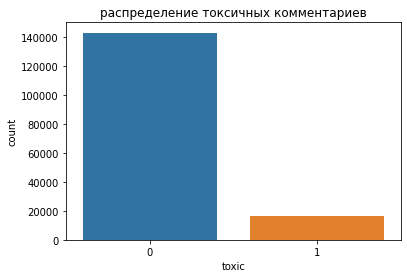

In [7]:
sns.countplot(x='toxic', data=data)
plt.title('распределение токсичных комментариев');

In [8]:
data.duplicated().sum()

0

явных дубликатов не найдено

напишем функцию очищения текстов постов

In [9]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

In [10]:
data['text'] = data['text'].apply(clear_text) 

напишем функцию РОS-тэгирования слов

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

напишем функцию леммализации тектов постов

In [14]:
nlp = spacy.load('en_core_web_sm')

In [15]:
new_corpus = []

for doc in tqdm(nlp.pipe(data['text'], batch_size=64, n_process=-1, disable=["parser", "ner"]), total=len(data['text'])):
    word_list = [tok.lemma_ for tok in doc]
    new_corpus.append(' '.join(word_list))

data['lemm_spacy_new'] = new_corpus  

100%|██████████| 159292/159292 [22:40<00:00, 117.11it/s]


In [16]:
data

,text,toxic,lemm_spacy_new
0,explanation why the edits made under my userna...,0,explanation why the edit make under my usernam...
1,d aww he matches this background colour i m se...,0,d aww he match this background colour I m seem...
2,hey man i m really not trying to edit war it s...,0,hey man I m really not try to edit war it s ju...
3,more i can t make any real suggestions on impr...,0,more I can t make any real suggestion on impro...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...
...,...,...,...
159287,and for the second time of asking when your vi...,0,and for the second time of ask when your view ...
159288,you should be ashamed of yourself that is a ho...,0,you should be ashamed of yourself that be a ho...
159289,spitzer umm theres no actual article for prost...,0,spitzer umm there s no actual article for pros...
159290,and it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


разделим данные на  выборки

In [17]:
features = data.drop(['toxic'], axis=1)

target = data['toxic']



features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)



In [18]:
features_train

,text,lemm_spacy_new
116419,that makes no sense you don t play maplestory ...,that make no sense you don t play maplestory t...
78749,numbers killled the existing text matches is s...,number killle the exist text match be similar ...
73523,privyet oct utc,privyet oct utc
157127,let him stop posting comments on my talk page ...,let he stop post comment on my talk page I m u...
51825,hello and welcome to wikipedia please remember...,hello and welcome to wikipedia please remember...
...,...,...
109993,hahaha i dont live in a lie like you and dont ...,hahaha I do not live in a lie like you and do ...
85412,march march,march march
133249,agreed we really should try to stick to the su...,agree we really should try to stick to the sub...
130333,umm killer do you not like that he copied your...,umm killer do you not like that he copy your w...


In [19]:
target

0         0
1         0
2         0
3         0
4         0
         ..
159287    0
159288    0
159289    0
159290    0
159291    0
Name: toxic, Length: 159292, dtype: int64

In [20]:
try:
    nltk.download('stopwords')
except:
    pass
#Объявляем набор стоп-слов 
try:
    stopwords = set(stopwords.words('english'))
except:
    pass
#Объявляем TFIDF-векторизатор
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


проверим размер выборок 

In [21]:
for i in [features_train, target_train, features_test, target_test]:
    print(i.shape)

(119469, 2)
(119469,)
(39823, 2)
(39823,)


In [22]:
features_train

,text,lemm_spacy_new
116419,that makes no sense you don t play maplestory ...,that make no sense you don t play maplestory t...
78749,numbers killled the existing text matches is s...,number killle the exist text match be similar ...
73523,privyet oct utc,privyet oct utc
157127,let him stop posting comments on my talk page ...,let he stop post comment on my talk page I m u...
51825,hello and welcome to wikipedia please remember...,hello and welcome to wikipedia please remember...
...,...,...
109993,hahaha i dont live in a lie like you and dont ...,hahaha I do not live in a lie like you and do ...
85412,march march,march march
133249,agreed we really should try to stick to the su...,agree we really should try to stick to the sub...
130333,umm killer do you not like that he copied your...,umm killer do you not like that he copy your w...


## Обучение

###  Логистическая регрессия 

In [23]:
features_train = features_train.lemm_spacy_new


In [33]:
%%time

#обучение:
pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)), 
                     ("lr", LogisticRegression())])
    
parameters = {'lr__solver': ('liblinear', 'saga','newton-cg', 'lbfgs'),
              'lr__C': (10, 15),
              'lr__random_state': ([12345]),
              'lr__max_iter': ([200]),
              'lr__class_weight': (['balanced'])} 
gscv_log = GridSearchCV(pipeline, parameters, scoring='f1', cv=3, n_jobs=-1)

gscv_log.fit(features_train, target_train)

mts = gscv_log.cv_results_['mean_test_score']
lr_train_f1 = max(mts)

print('F1 логистической регрессии =', round(lr_train_f1,5))
print('при параметрах:', gscv_log.best_params_)


#тестирование:
#predictions_test = gscv.predict(features_test.text)
#lr_test_f1 = f1_score(target_test, predictions_test)
#print('финальный F1 логистической регрессии =', round(lr_test_f1,2))

F1 логистической регрессии = 0.76252
при параметрах: {'lr__C': 15, 'lr__class_weight': 'balanced', 'lr__max_iter': 200, 'lr__random_state': 12345, 'lr__solver': 'saga'}
CPU times: user 11min 9s, sys: 8min 16s, total: 19min 26s
Wall time: 19min 30s


###  SGDClassifier

In [34]:
%%time
pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english')), 
                     ("clf", SGDClassifier())])
    
parameters = {'clf__loss': ('hinge', 'log', 'modified_huber'),
              'clf__learning_rate': ('constant', 'optimal', 'invscaling', 'adaptive'),
              'clf__eta0': (.01, .05, .1, .5),
              'clf__random_state': ([12345]),
              'clf__class_weight': (['balanced'])}

gscv_sgd = GridSearchCV(pipeline, parameters, scoring='f1', cv=3, n_jobs=-1)

gscv_sgd.fit(features_train, target_train)

mts = gscv_sgd.cv_results_['mean_test_score']
sgdc_train_f1 = max(mts)

print('F1 SGDClassifier =', round(sgdc_train_f1,5))
print('при параметрах:', gscv_sgd.best_params_)




F1 SGDClassifier = 0.75086
при параметрах: {'clf__class_weight': 'balanced', 'clf__eta0': 0.01, 'clf__learning_rate': 'adaptive', 'clf__loss': 'modified_huber', 'clf__random_state': 12345}
CPU times: user 17min 13s, sys: 7.14 s, total: 17min 20s
Wall time: 17min 27s


## Выводы

протестируем модель логистической регрессии на тестовой выборке 

In [36]:
#тестирование:
predictions_test = gscv_log.predict(features_test.text)
lr_test_f1 = f1_score(target_test, predictions_test)
print('финальный F1 логистической регрессии =', round(lr_test_f1,3))

финальный F1 логистической регрессии = 0.754


Таким образом, в проекте загрузил данные и провел их предобработку(удалил лишние данные, провел очистку текстов, лемматизацию), обучил модели с разными гиперпараметрами и выборками и проверил их на тестовой выборк,  по показателю F1 лучше показала себя модель логистической регрессии